# PCA

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

#zillow = pd.read_csv('../../data/zillow_full_imputed.csv')

%run ../Jane/extract_data.py

Your data is ready! Merged table name is zillow_full


In [11]:
# separate the cols that won't go into the pca
zillow = zillow_full[['Zipcode','City','State','Metro','County','SizeRank','Date','Rent','Year','State-County']]
features = zillow_full.drop(['Zipcode','City','State','Metro','County','SizeRank','Date','Rent',
                             'Year','State-County'], axis = 1).copy()

In [13]:
scaler = StandardScaler()

features = pd.DataFrame(scaler.fit_transform(features),columns=features.columns)
features.head()

,AQIMean,PersonalIncome,Vol_moderate_income,Vol_low_income,total_pop,households,median_age,median_income,income_per_capita,gini_index,pct_poverty,housing_availability,home_density,pct_employed,pct_jobs_nightlife,pct_unemployed,move_within_city,move_new_city,avg_commute_time,pct_college
0,1.677669,-0.483885,-2.303187,-2.555039,2.052326,3.096986,0.677914,0.395570,1.127500,2.090545,-0.116861,0.165373,-0.951186,-0.203258,-0.502295,0.218105,0.557787,-0.131412,-0.253440,0.459031
1,1.677669,-0.483885,-2.303187,-2.555039,0.708930,2.065297,1.069040,1.794826,2.899726,1.450117,-0.854462,0.768800,-1.658710,0.635772,-0.646796,-0.606914,0.220614,-0.386784,-0.603104,1.019498
2,1.677669,-0.483885,-2.303187,-2.555039,1.264424,2.046087,1.127709,-1.178083,-0.401966,1.861821,1.410115,-0.524889,-0.909010,-0.314296,1.564514,0.339607,-0.408679,-0.828548,-0.196208,-0.075481
3,1.677669,-0.483885,-2.303187,-2.555039,2.382845,2.446985,-0.612804,-0.669162,-0.655060,-0.261799,0.216671,-0.271246,0.058214,-0.382420,-0.115327,0.407477,-0.598288,-0.990002,1.160614,-0.619263
4,1.861551,-0.483885,-2.303187,-2.555039,2.535674,2.446860,-0.808367,-1.141751,-0.920356,0.053137,1.436812,-0.650615,0.242537,-2.372156,0.573144,2.389787,0.799210,-1.038250,1.299683,-1.127515


In [107]:
# # try a correlation heat map to assess for multicollinearity
# plt.figure(figsize=(16, 10)) # larger for ease of viewing

# heatmap = sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Feature Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

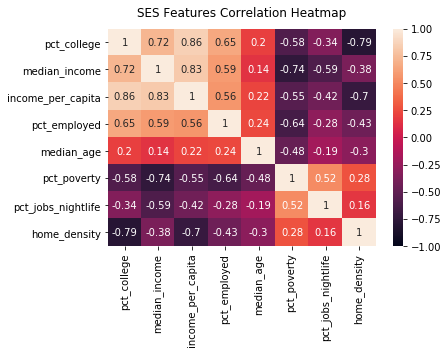

In [49]:
socio_econ = features[['pct_college','median_income','income_per_capita','pct_employed','median_age','pct_poverty',
                'pct_jobs_nightlife','home_density']]
heatmap = sns.heatmap(socio_econ.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('SES Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [85]:
def screePlot(df):
    pca = PCA(n_components=df.shape[1]) 
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    plt.plot((np.arange(pca.n_components_)+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('# Principal Components')
    plt.ylabel('% of Variance Explained')
    plt.show()

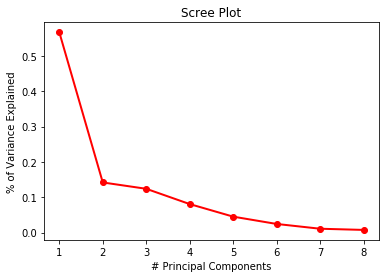

In [53]:
screePlot(socio_econ) # take 4 pcs

In [91]:
pca = PCA(n_components=4) 
econPC = pd.DataFrame(pca.fit_transform(socio_econ),columns=['econPC1','econPC2','econPC3','econPC4'])

### remove features involved in the above PCA

In [62]:
features = features.drop(['pct_college','median_income','income_per_capita','pct_employed','median_age',
                          'pct_poverty','pct_jobs_nightlife','home_density'],axis=1)

In [108]:
# plt.figure(figsize=(10, 6)) 
# heatmap = sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

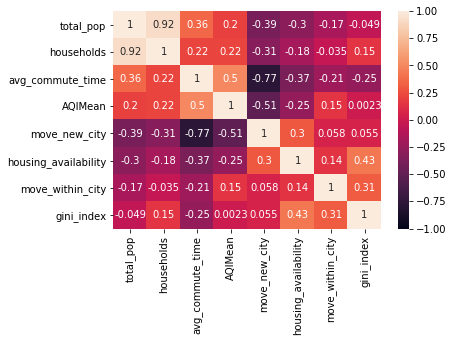

In [83]:
cityfeats = features[['total_pop','households','avg_commute_time','AQIMean','move_new_city','housing_availability',
                'move_within_city','gini_index']]
heatmap = sns.heatmap(cityfeats.corr(), vmin=-1, vmax=1, annot=True)

[0.38006506 0.19856027 0.16718694 0.10596215 0.05991504 0.05747845
 0.02437764 0.00645446]


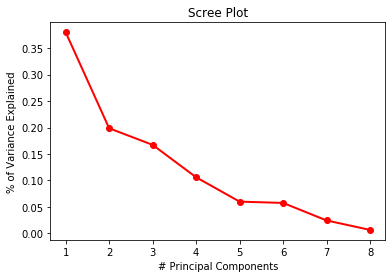

In [86]:
screePlot(cityfeats)

In [90]:
pca = PCA(n_components=5) 
cityPC = pd.DataFrame(pca.fit_transform(cityfeats),columns=['cityPC1','cityPC2','cityPC3','cityPC4','cityPC5'])

In [102]:
features = features.drop(['total_pop','households','avg_commute_time','AQIMean','move_new_city',
                          'housing_availability','move_within_city','gini_index'],axis=1)

features = features.drop('pct_unemployed',axis=1)

In [120]:
zillow_withPCA = pd.concat((zillow,features,cityPC,econPC),axis=1)
zillow_withPCA.set_index('Date',inplace=True)
zillow_withPCA.sample()

,Zipcode,City,State,Metro,County,SizeRank,Rent,Year,State-County,PersonalIncome,...,Vol_low_income,cityPC1,cityPC2,cityPC3,cityPC4,cityPC5,econPC1,econPC2,econPC3,econPC4
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-01,11370,New York,NY,New York-Newark-Jersey City,Queens County,1747,2192.0,2016,NY-Queens County,-0.36724,...,0.603387,0.854545,1.044092,3.034108,-0.904223,-1.999371,1.553029,-1.823399,-0.357135,-1.448693


## random forest

In [127]:
LE = LabelEncoder() #sklearn.preprocessing

def preProc(zillow_df, ytype='log'):
    features = zillow_df.drop(['Rent','State-County','State'],axis=1)
    cat_cols = features.select_dtypes(include = object).copy()
    num_cols = features.select_dtypes(exclude = object).copy()
    for col in cat_cols.columns:
        cat_cols[col] = LE.fit_transform(cat_cols[col])
    
    X = pd.concat([cat_cols,num_cols],axis=1)
    
    if ytype == 'log':
        y = np.log(zillow_df['Rent'])
    elif ytype == 'normal':
        y = zillow_df['Rent']
    return X,y

def train_test(X,y):
    Xtrain = X.loc[X.index <'2019-01-01']
    train_index = Xtrain.shape[0]
    Xtest = X[train_index:]
    ytrain = y[:train_index]
    ytest = y[train_index:]
    return Xtrain,Xtest,ytrain,ytest

def randForest(model,Xtrain,Xtest,ytrain,ytest):
    model.fit(Xtrain,ytrain)
    print(f'training R2: {model.score(Xtrain,ytrain)}')
    print(f'test R2: {model.score(Xtest,ytest)}')
    
    ypred = rfc.predict(Xtest)
    RMSE = mean_squared_error(ytest,ypred, squared = False)
    print(f'RMSE: {RMSE}')
    
    feature_imps = pd.DataFrame({'Columns':Xtrain.columns,'Feature_importances':model.feature_importances_})
    return feature_imps.sort_values('Feature_importances',ascending=False)

In [124]:
X,y = preProc(zillow_withPCA,ytype='log')
Xtrain,Xtest,ytrain,ytest = train_test(X,y)
randForest(rfc,Xtrain,Xtest,ytrain,ytest)

In [129]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor()

randForest(rfc,Xtrain,Xtest,ytrain,ytest)

training R2: 0.999435677448131
test R2: 0.9839755073003001
RMSE: 0.035879181285339075


,Columns,Feature_importances
2,Metro,0.392328
14,econPC1,0.268005
0,Zipcode,0.136307
15,econPC2,0.068581
3,County,0.033059
16,econPC3,0.027631
6,PersonalIncome,0.014401
4,SizeRank,0.009501
9,cityPC1,0.009428
17,econPC4,0.009233


In [131]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## grid search to parameter tune

In [134]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':[100,150,200,250,300,400,500],
             'max_depth':[None,1,2,3]}

grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid,return_train_score=True)


In [135]:
grid.fit(Xtrain,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [138]:
rfc.set_params(**grid.best_params_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [142]:
randForest(rfc,Xtrain,Xtest,ytrain,ytest)

training R2: 0.9994366696832208
test R2: 0.9838947396852935
RMSE: 0.03596948784343751


,Columns,Feature_importances
2,Metro,0.392224
14,econPC1,0.268162
0,Zipcode,0.136895
15,econPC2,0.069056
3,County,0.033761
16,econPC3,0.027272
6,PersonalIncome,0.014327
9,cityPC1,0.009478
4,SizeRank,0.009245
17,econPC4,0.008711
